In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import uuid

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

# Load dataset from local directory
data_dir = 'C:\\Users\\Student\\Desktop\\BD\\Animal Data'
class_names = ['cats', 'dogs', 'snakes']
image_size = (64, 64)  # Resize images to 64x64 for consistency
X, y = [], []
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            X.append(img_array)
            y.append(label)
        except:
            print(f"Error loading image: {img_path}")

X = np.array(X)
y = np.array(y)

In [9]:
# Split dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Flatten images for SVM, Random Forest, and AdaBoost
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features for SVM
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

# Encoding labels for neural networks
y_train_cat = to_categorical(y_train, len(class_names))
y_test_cat = to_categorical(y_test, len(class_names))

# Preprocess images for ResNet50 (ImageNet preprocessing)
X_train_resnet = np.array([preprocess_input(img * 255.0) for img in X_train])
X_test_resnet = np.array([preprocess_input(img * 255.0) for img in X_test])

In [10]:
# Function to evaluate and plot confusion matrix
def evaluate_model(model, X_test, y_test, model_name, is_keras=False):
    if is_keras:
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)
    else:
        y_pred = model.predict(X_test)
        y_true = y_test
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}_{uuid.uuid4().hex}.png'
    plt.savefig(filename)  # Save as PNG for submission
    plt.show()  # Display on screen
    plt.close()
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'cm': cm, 'cm_filename': filename}

# Dictionary to store evaluation results
results = {}

Training Random Forest...
Best Random Forest Parameters: {'max_depth': 20, 'n_estimators': 200}

Random Forest Performance:
Accuracy: 0.6083
Precision: 0.6125
Recall: 0.6083
F1-Score: 0.6084


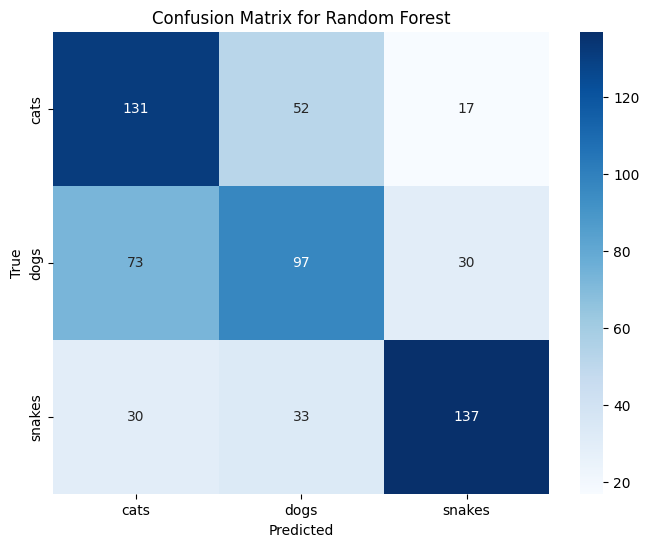

In [11]:
# 1. Random Forest Model
print("Training Random Forest...")
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_jobs=-1)
rf.fit(X_train_flat, y_train)
print("Best Random Forest Parameters:", rf.best_params_)
results['Random Forest'] = evaluate_model(rf, X_test_flat, y_test, "Random Forest")

Training AdaBoost...
Best AdaBoost Parameters: {'learning_rate': 1.0, 'n_estimators': 100}

AdaBoost Performance:
Accuracy: 0.5067
Precision: 0.5177
Recall: 0.5067
F1-Score: 0.5098


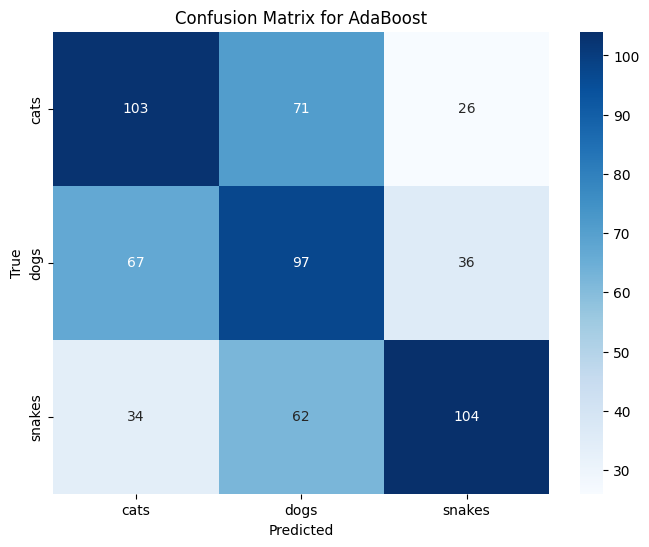

In [12]:
# 2. AdaBoost Model
print("Training AdaBoost...")
ada_params = {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}
ada = GridSearchCV(AdaBoostClassifier(random_state=42), ada_params, cv=3, n_jobs=-1)
ada.fit(X_train_flat, y_train)
print("Best AdaBoost Parameters:", ada.best_params_)
results['AdaBoost'] = evaluate_model(ada, X_test_flat, y_test, "AdaBoost")

Training SVM...
Best SVM Parameters: {'C': 10, 'degree': 2, 'kernel': 'rbf'}

SVM Performance:
Accuracy: 0.6317
Precision: 0.6384
Recall: 0.6317
F1-Score: 0.6325


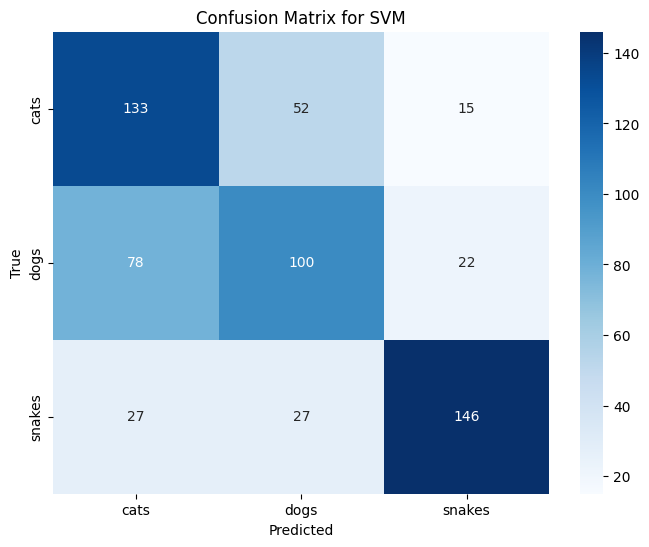

In [13]:
# 3. SVM Model
print("Training SVM...")
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3]  # Only used for poly kernel
}
svm = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1)
svm.fit(X_train_flat, y_train)
print("Best SVM Parameters:", svm.best_params_)
results['SVM'] = evaluate_model(svm, X_test_flat, y_test, "SVM")

Training KNN...
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

KNN Performance:
Accuracy: 0.5383
Precision: 0.5451
Recall: 0.5383
F1-Score: 0.5397


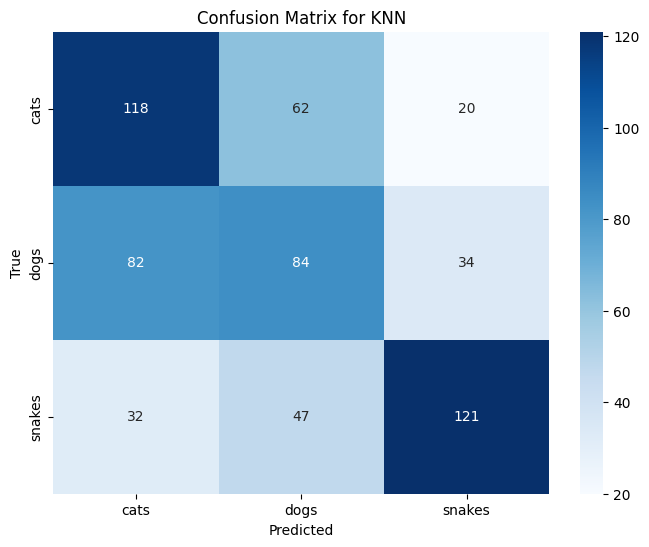

In [34]:
# 4. K-Nearest Neighbors (KNN)
print("Training KNN...")
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_flat, y_train)
print(f"Best KNN Parameters: {grid_knn.best_params_}")
results['KNN'] = evaluate_model(grid_knn.best_estimator_, X_test_flat, y_test, "KNN")


Training CNN...
Epoch 1/10


C:\Users\Student\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4069 - loss: 1.0994
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6160 - loss: 0.8075
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6848 - loss: 0.6976
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7518 - loss: 0.5986
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7571 - loss: 0.5683
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8002 - loss: 0.4734
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8320 - loss: 0.4233
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8721 - loss: 0.3455
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8858 - loss: 0.2876
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8958 - loss: 0.2538
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

CNN Performance:
Accuracy: 0.7567
Precision: 0.7580
Recall: 0.7567
F1-Score: 0.7559


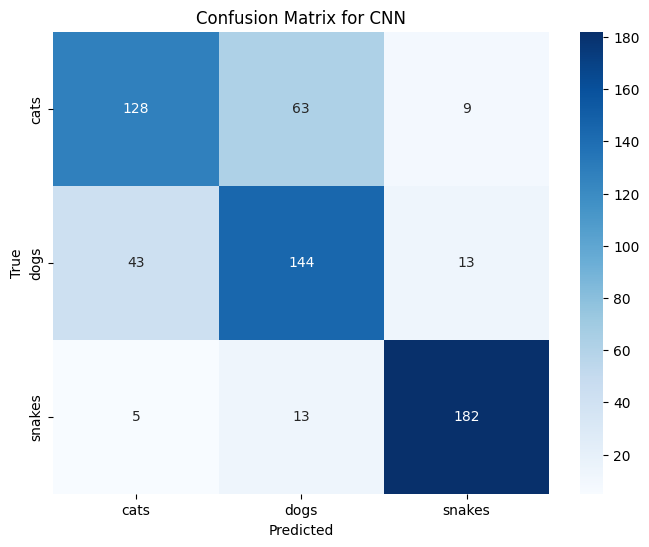

In [37]:
# 5. Convolutional Neural Network (CNN)
print("Training CNN...")
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])
# Compile and train the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train_cat, epochs=10, batch_size=32, verbose=1)

# Evaluate the results
results['CNN'] = evaluate_model(cnn, X_test, y_test_cat, "CNN", is_keras=True)


Training ResNet50...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.7083 - loss: 1.8623 - val_accuracy: 0.8650 - val_loss: 0.4331
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8775 - loss: 0.3358 - val_accuracy: 0.8700 - val_loss: 0.3700
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9040 - loss: 0.2463 - val_accuracy: 0.8750 - val_loss: 0.3715
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9329 - loss: 0.1606 - val_accuracy: 0.8650 - val_loss: 0.3954
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9364 - loss: 0.1674 - val_accuracy: 0.8700 - val_loss: 0.4310
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9488 - loss: 0.1403 - val_accuracy: 0.8817 - val_loss: 0.4140
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9416 - loss: 0.1443 - val_accuracy: 0.8783 - val_loss: 0.4585
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.9534 - loss: 0.1

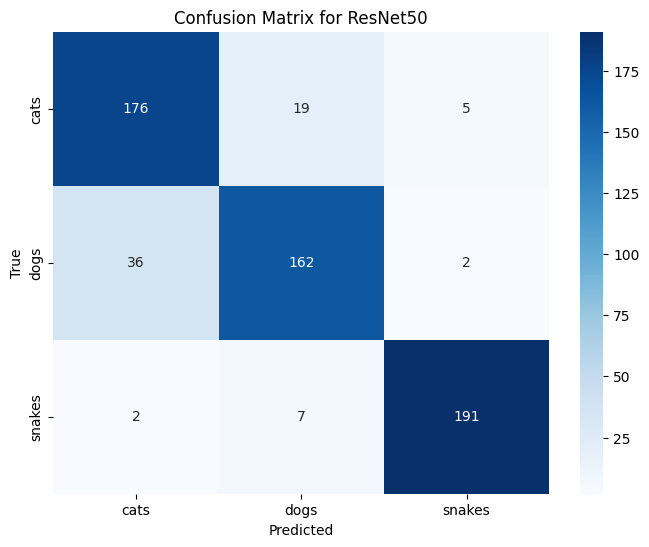

In [ ]:
print("Training ResNet50...")
# Load and configure ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = False  # Freeze base model layers

# Build the model
resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])
# Compile the model
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model with validation data
history = resnet.fit(
    X_train_resnet, 
    y_train_cat, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_resnet, y_test_cat),  # Use test set as validation
    verbose=1
)
# Evaluate the results
print("\nResNet50 Evaluation Metrics:")
results['ResNet50'] = evaluate_model(resnet, X_test_resnet, y_test_cat, "ResNet50", is_keras=True)

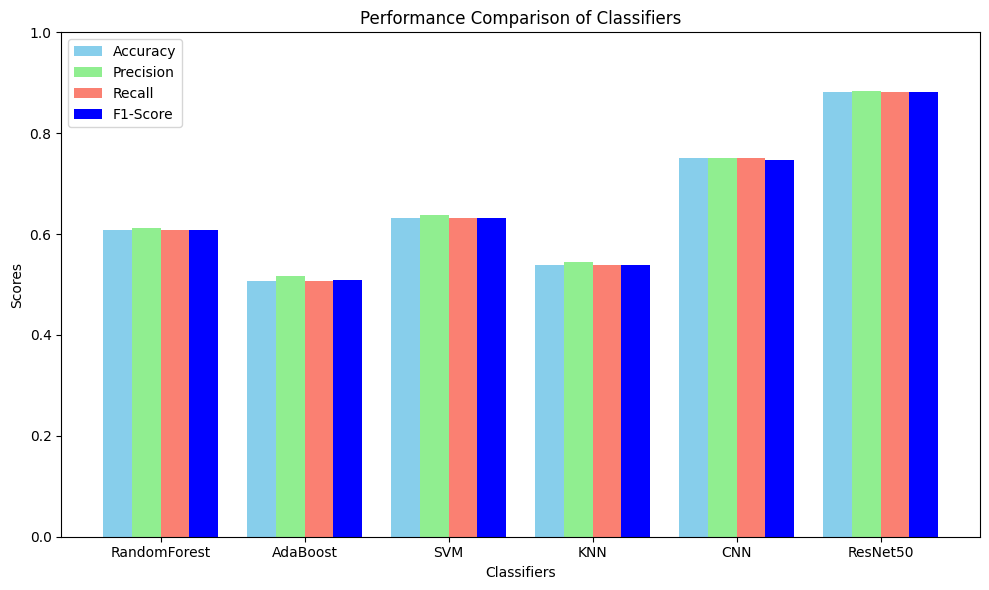

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the notebook's summary of model performance
classifiers = ['RandomForest', 'AdaBoost', 'SVM', 'KNN', 'CNN', 'ResNet50']
metrics = {
    'Accuracy': [0.6083, 0.5067,0.6317,0.5383,0.7517,0.8817],
    'Precision': [0.6125, 0.5177, 0.6384, 0.5451, 0.7502, 0.8829],
    'Recall': [0.6083,0.5067,0.6317,0.5383, 0.7517, 0.8817],
    'F1-Score': [0.6084,0.5098,0.6325,0.5397, 0.7476, 0.8817]
}

# Plotting parameters
x = np.arange(len(classifiers))  # Label locations
width = 0.2  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
ax.bar(x - 1.5*width, metrics['Accuracy'], width, label='Accuracy', color='skyblue')
ax.bar(x - 0.5*width, metrics['Precision'], width, label='Precision', color='lightgreen')
ax.bar(x + 0.5*width, metrics['Recall'], width, label='Recall', color='salmon')
ax.bar(x + 1.5*width, metrics['F1-Score'], width, label='F1-Score', color='blue')

# Customize the plot
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1] for clarity
plt.tight_layout()

# Show the plot
plt.show()